In [1]:
#import library
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import interpolate
from tqdm import tqdm

In [2]:
# define the Interpolation function
def inp(x,t):
    f = interpolate.interp1d(t,x, kind='linear')
    x_new=list(np.linspace(t.min(),t.max(),num=500))
    return np.array(list(f(x_new)))

In [3]:
#select target batch
#for example I rename 2017-05-12_batchdata_updated_struct_errorcorrect.mat as 1.mat
target=1
matFilename = '%d.mat'%(target)
f = h5py.File(matFilename,'r')
list(f.keys())
batch = f['batch']
list(batch.keys())
num_cells = batch['summary'].shape[0]

In [16]:
#select cell should be deleted 
#note that this index is only for discharging model 
#it would occur some bugs on charging part as following image shown
dee1=np.array([1,2,3,4,5,9,11,13,14,19,23])-1
dee2=np.array([2,7,10,11,22,26])-1
dee3=np.array([24,33,38])-1
del_data=[dee1,dee2,dee3]

100%|██████████| 46/46 [04:51<00:00,  6.34s/it]


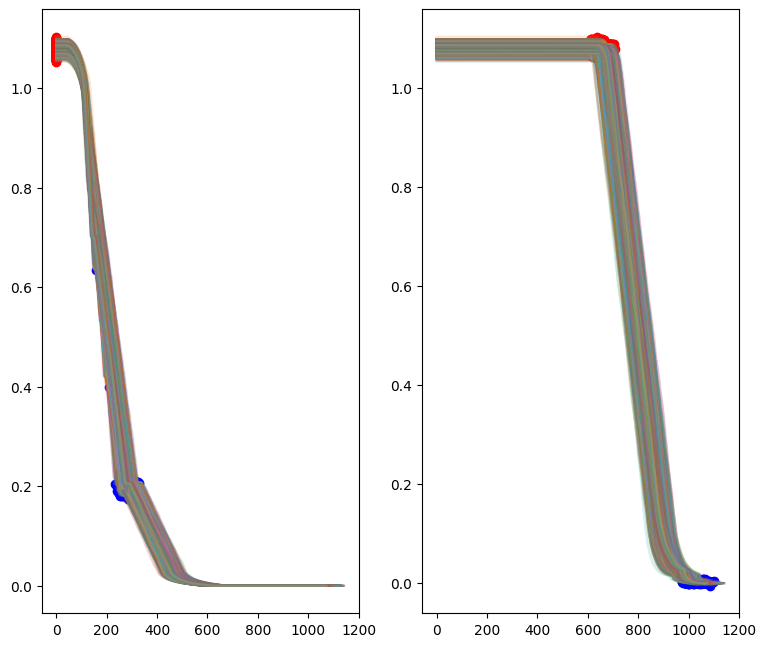

In [7]:
#create list to collect data
eol=[]
cycle_data_ch=[]
cycle_data_dis=[]

#data visualization
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(9,8),dpi=100)

#collect the data through batch
for i in tqdm(range(num_cells)):
    if (del_data[target-1]==i).sum()==0:
        cycles = f[batch['cycles'][i,0]]
        cl = f[batch['cycle_life'][i,0]][0]

        ct = f[batch['summary'][i,0]]['chargetime'][0,:].tolist()
        eol.append(cl)
        #get the first 100 cycle data 
        for j in range(100): 
            current_cycle=j+1
            
            #get data from mat file
            t = np.hstack((f[cycles['t'][current_cycle,0]]))
            qd = np.hstack((f[cycles['Qd'][current_cycle,0]]))
            qc = np.hstack((f[cycles['Qc'][current_cycle,0]]))
            v = np.hstack((f[cycles['V'][current_cycle,0]]))
            cu = np.hstack((f[cycles['I'][current_cycle,0]]))
            temp = np.hstack((f[cycles['T'][current_cycle,0]]))
            Qdlin = np.hstack((f[cycles['Qdlin'][current_cycle,0]]))
            
            # find the start and end point of charging and discharge part
            new=np.zeros_like(qc)
            d=qc.max()-Qdlin
            r=qc.max()-qd
            g=qc.max()-qc
            dd=np.diff(np.diff(qd))    
            dis_s=np.where(np.diff(qd)>=1e-3)[0][0]
            ch_e=np.where(cu==0)[0][1]
            ch_s=0
            dis_e=np.where(dd>1e-4)[0][-1]+1
            new[:dis_s]=qc[:dis_s]
            new[dis_s:]=r[dis_s:]
            
            # plot capacity curve, if you don't want please delete 
            axes[0].plot(g,alpha=0.2)
            axes[0].scatter(ch_s,g[ch_s],c='r')
            axes[0].scatter(ch_e,g[ch_e],c='b')
            
            axes[1].plot(r,alpha=0.2)
            axes[1].scatter(dis_s,r[dis_s],c='r')
            axes[1].scatter(dis_e,r[dis_e],c='b')
            
            # interpolate data
            
            #capacity
            new1=inp(new[ch_s:ch_e],t[ch_s:ch_e])# charging part 
            new2=inp(new[dis_s:dis_e],t[dis_s:dis_e]) # discharging part 
            # temperature
            temp1=inp(temp[ch_s:ch_e],t[ch_s:ch_e])
            temp2=inp(temp[dis_s:dis_e],t[dis_s:dis_e])
            #current
            cu1=inp(cu[ch_s:ch_e],t[ch_s:ch_e])
            cu2=inp(cu[dis_s:dis_e],t[dis_s:dis_e])
            #voltage
            v1=inp(v[ch_s:ch_e],t[ch_s:ch_e])
            v2=inp(v[dis_s:dis_e],t[dis_s:dis_e])
            
            #collect variable to list
            cycle_data_ch.append(new1)
            cycle_data_ch.append(v1)
            cycle_data_ch.append(cu1)
            cycle_data_ch.append(temp1)
            
            cycle_data_dis.append(new2)
            cycle_data_dis.append(v2)
            cycle_data_dis.append(cu2)
            cycle_data_dis.append(temp2)

In [10]:
# convert list to array
cycle_data_dis=np.array(cycle_data_dis).reshape(-1,100,4,500) #(number of cell, first n cycle, property, time-series data)
cycle_data_ch=np.array(cycle_data_ch).reshape(-1,100,4,500) #(number of cell, first n cycle, property, time-series data)
eol=np.array(eol).reshape(-1,1)
#save data
np.save('eol',eol)
np.save('cycle_data_dis.npy',cycle_data_dis)
np.save('cycle_data_ch.npy',cycle_data_ch)


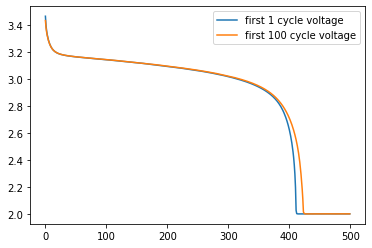

In [15]:
#check
charge=np.load('cycle_data_dis.npy')
plt.plot(charge[0,0,1],label='first 1 cycle voltage')
plt.plot(charge[0,99,1],label='first 100 cycle voltage')
plt.legend()